# SMILES enumeration, vectorization and batch generation

[![Smiles Enumeration Header](https://www.wildcardconsulting.dk/wp-content/uploads/2017/03/Smiles_Enumeration_girl_600px.png)](https://www.wildcardconsulting.dk/useful-information/smiles-enumeration-as-data-augmentation-for-molecular-neural-networks/)

SMILES enumeration is the process of writing out all possible SMILES forms of a molecule. It's a useful technique for data augmentation before sequence based modeling of molecules. You can read more about the background in this [blog post](https://www.wildcardconsulting.dk/useful-information/smiles-enumeration-as-data-augmentation-for-molecular-neural-networks/) or [this preprint on arxiv.org](https://arxiv.org/abs/1703.07076)

Import the SmilesEnumerator and instantiate the object

In [1]:
from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator()
print help(SmilesEnumerator)

Help on class SmilesEnumerator in module SmilesEnumerator:

class SmilesEnumerator(__builtin__.object)
 |  SMILES Enumerator, vectorizer and devectorizer
 |  
 |  #Arguments
 |      charset: string containing the characters for the vectorization
 |        can also be generated via the .fit() method
 |      pad: Length of the vectorization
 |      leftpad: Add spaces to the left of the SMILES
 |      isomericSmiles: Generate SMILES containing information about stereogenic centers
 |      enum: Enumerate the SMILES during transform
 |      canonical: use canonical SMILES during transform (overrides enum)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, charset=r'@C)(=cOn1S2/H[N]\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False)
 |  
 |  fit(self, smiles, extra_chars=[], extra_pad=5)
 |      Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset
 |      
 |      #Arguments
 |          smiles: Numpy array or Pand

A few SMILES strings will be enumerated as a demonstration.

In [2]:
for i in range(10):
    print sme.randomize_smiles("CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2")

c1([C@@]2(OC(=O)CC)CC[NH+](C)C[C@H]2CC=C)ccccc1
c1ccc([C@]2(OC(=O)CC)[C@H](CC=C)C[NH+](C)CC2)cc1
c1ccccc1[C@@]1(OC(CC)=O)CC[NH+](C)C[C@H]1CC=C
O=C(CC)O[C@]1(c2ccccc2)CC[NH+](C)C[C@H]1CC=C
C[NH+]1CC[C@](OC(=O)CC)(c2ccccc2)[C@H](CC=C)C1
C1[C@@](c2ccccc2)(OC(CC)=O)[C@H](CC=C)C[NH+](C)C1
[C@]1(c2ccccc2)(OC(=O)CC)CC[NH+](C)C[C@H]1CC=C
c1([C@@]2(OC(CC)=O)CC[NH+](C)C[C@H]2CC=C)ccccc1
[C@@H]1(CC=C)C[NH+](C)CC[C@]1(OC(=O)CC)c1ccccc1
c1cccc([C@@]2(OC(=O)CC)CC[NH+](C)C[C@H]2CC=C)c1


## Vectorization

Before vectorization SMILES must be stored as strings in an numpy array. The transform takes numpy arrays or pandas series with the SMILES as strings.

In [5]:
import numpy as np
smiles = np.array(["CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2"])
print smiles.shape

(1,)


Fit the charset and the padding to the SMILES array, alternatively they can be specified when instantiating the object.

In [6]:
sme.fit(smiles)
print sme.charset
print sme.pad

@C)(+=cON12H[]
50


There have been added some extra padding to the maximum lenght observed in the smiles array. The SMILES can be transformed to one-hot encoded vectors and showed with matplotlib.

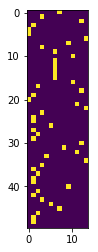

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
vect = sme.transform(smiles)
plt.imshow(vect[0])

It's a nice piano roll. If the vectorization is repeated, the vectorization will be different due to the enumeration, as sme.enum and sme.canonical is set to True and False, respectively (default settings).

True False


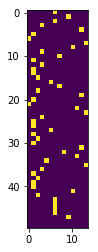

In [8]:
print sme.enumerate, sme.canonical
vect = sme.transform(smiles)
plt.imshow(vect[0])

The reverse_transform() function can be used to translate back to a SMILES string, as long as the charset is the same as was used to vectorize.

In [7]:
print sme.reverse_transform(vect)

['C(C[C@@H]1C[NH+](C)CC[C@@]1(c1ccccc1)OC(CC)=O)=C']


## Batch generation for Keras RNN modeling

The SmilesEnumerator class can be used together with the SmilesIterator batch generator for on the fly vectorization for RNN modeling of molecules. Below it's briefly demonstrated how this can be done.

In [10]:
import pandas as pd

data = pd.read_csv("Example_data/Sutherland_DHFR.csv")
print data.head()

   Unnamed: 0                                      smiles_parent PC_uM_sign  \
0           0                      CCc1nc(N)nc(N)c1-c1ccc(Cl)cc1        NaN   
1           1                  CCc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1        NaN   
2           2                   Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1        NaN   
3           3                CCOCc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1        NaN   
4           4  Nc1nc(N)c(-c2ccc(Cl)cc2)c(COc2ccc([N+](=O)[O-]...        NaN   

   PC_uM_value  
0         3.70  
1         1.08  
2         1.68  
3        12.70  
4        85.10  


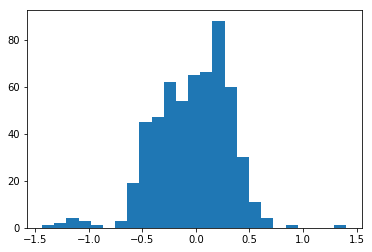

In [11]:
from sklearn.cross_validation import train_test_split

#We ignore the > signs, and use random splitting for simplicity
X_train,  X_test, y_train, y_test = train_test_split(data["smiles_parent"],
                                                     np.log(data["PC_uM_value"]).values.reshape(-1,1),
                                                     random_state=42)

from sklearn.preprocessing import RobustScaler
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
y_train = rbs.fit_transform((y_train))
y_test = rbs.transform(y_test)
_ = plt.hist(y_train, bins=25)

In [12]:
import keras.backend as K
from SmilesEnumerator import SmilesIterator
#The SmilesEnumerator must be fit to the entire dataset, so that all chars are registered
sme.fit(data["smiles_parent"])
sme.leftpad = True
print sme.charset
print sme.pad
#The dtype is set for the K.floatx(), which is the numerical type configured for Tensorflow or Theano
generator = SmilesIterator(X_train, y_train, sme, batch_size=200, dtype=K.floatx())

Using TensorFlow backend.


CBFIHcONS[r]#)(+-lon1s3254=
75


In [83]:
X,y = generator.next()
print X.shape
print y.shape

(200, 75, 27)
(200, 1)


Build a SMILES based RNN QSAR model with Keras.

In [84]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.optimizers import RMSprop, Adam

In [131]:
input_shape = X.shape[1:]
output_shape = 1

model = Sequential()
model.add(LSTM(64,
               input_shape=input_shape,
               dropout = 0.19
               #unroll= True
              ))
model.add(Dense(output_shape,
                kernel_regularizer=regularizers.l1_l2(0.005,0.01),
                activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(lr=0.005))
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 64)                23552     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 23,617
Trainable params: 23,617
Non-trainable params: 0
_________________________________________________________________
None


Use the generator object for training.

In [132]:
model.fit_generator(generator, steps_per_epoch=100, epochs=25, workers=4)

Epoch 1/25
100/100 [==============================] - 20s 203ms/step - loss: 0.15431s - loss
Epoch 2/25
100/100 [==============================] - 16s 156ms/step - loss: 0.1090
Epoch 3/25
100/100 [==============================] - 16s 156ms/step - loss: 0.09302s - loss: - ETA: 1s - l
Epoch 4/25
100/100 [==============================] - 16s 159ms/step - loss: 0.0830
Epoch 5/25
100/100 [==============================] - 16s 157ms/step - loss: 0.0773
Epoch 6/25
100/100 [==============================] - 15s 155ms/step - loss: 0.07310s - loss: 0.07
Epoch 7/25
100/100 [==============================] - 16s 155ms/step - loss: 0.0698
Epoch 8/25
100/100 [==============================] - 16s 156ms/step - loss: 0.0679
Epoch 9/25
100/100 [==============================] - 15s 155ms/step - loss: 0.0676
Epoch 10/25
100/100 [==============================] - 15s 155ms/step - loss: 0.0635
Epoch 11/25
100/100 [==============================] - 16s 156ms/step - loss: 0.06191s - loss: 0.062 - ETA: 1s 

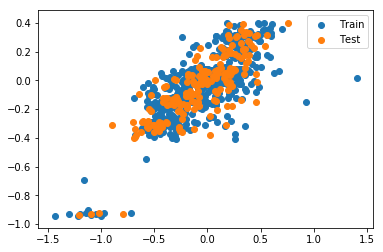

In [133]:
y_pred_train = model.predict(sme.transform(X_train))
y_pred_test = model.predict(sme.transform(X_test))
plt.scatter(y_train, y_pred_train, label="Train")
plt.scatter(y_test, y_pred_test, label="Test")
plt.legend()

Not the best model until now. However, prolonged training with lowering of the learning rate towards the end will improve the model.

In [149]:
#The Enumerator can be used in sampling
i = 1

y_true = y_test[i]
y_pred = model.predict(sme.transform(X_test.iloc[i:i+1]))
print y_true - y_pred

[[-0.38300244]]


0.0616476
[-0.10707214]


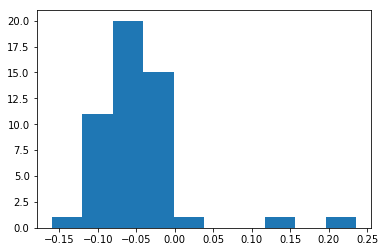

In [151]:
#Enumeration of the SMILES before sampling stabilises the result
smiles_repeat = np.array([X_test.iloc[i:i+1].values[0]]*50)
y_pred = model.predict(sme.transform(smiles_repeat))
print y_pred.std()
print y_true - np.median(y_pred)
_ = plt.hist(y_pred)

## Bibliography

Please cite: [SMILES enumeration as Data Augmentation for Network Modeling of Molecules](https://arxiv.org/abs/1703.07076)

```bibtex
@article{DBLP:journals/corr/Bjerrum17,
  author    = {Esben Jannik Bjerrum},
  title     = {{SMILES} Enumeration as Data Augmentation for Neural Network Modeling
               of Molecules},
  journal   = {CoRR},
  volume    = {abs/1703.07076},
  year      = {2017},
  url       = {http://arxiv.org/abs/1703.07076},
  timestamp = {Wed, 07 Jun 2017 14:40:38 +0200},
  biburl    = {http://dblp.uni-trier.de/rec/bib/journals/corr/Bjerrum17},
  bibsource = {dblp computer science bibliography, http://dblp.org}
}
```


If you find it useful, feel welcome to leave a comment on the [blog.](https://www.wildcardconsulting.dk/useful-information/smiles-enumeration-as-data-augmentation-for-molecular-neural-networks/) 